##### Submitted by Rizu Jain (430000753)

# EmoContext (Semeval 2019 Task): Detecting emotions in text 

## (a) Motivation

'Alexa','Ok Google' and 'Siri' have become one of the first few words that babies are learning to speak. Initial lessons in linguistic are learnt by imitation. Hearing these words so often from their parents and everyone around, they tend to mimic them. Such is the presence of AI agents in our lives. However, oftentimes their responses sound apathetic. A trait to imporve is 'EMPATHY'.

#### 'Empathy' - the ability to understand and share the feelings of another.

Naturally, there is a huge demand for understanding emotions. Especially, with just speech or text as input given that visuals aren't the mode of communication with these agents.

Emotions are ambigious and subjective. Lack of facial expressions and voice modulations make detecting emotions in text a challenging problem.

However, as we increasingly communicate using text messaging applications and digital agents, contextual 
emotion detection in text is gaining importance to provide emotionally aware responses to users. 

## Data
[https://www.humanizing-ai.com/emocontext.html]

In this task, we are given a textual dialogue i.e. a user utterance along with two turns of context, you have to classify the emotion of user utterance as one of the emotion classes: Happy, Sad, Angry or Others. 

The data is provided in development and train sets which has been merged for the purpose of this project. The number of labels are roughly half in 'others' and half in the 'Happy', 'Sad' and 'Angry' emotions.


## (b) Problem Formulation

The problem at hand is a supervised classification problem. We will be relying on the sentence utterances for emotion classification.

Now, as we have 3 utterances, we will generate 3 sentence embeddings using those 3 utterances. The rational is that we will be able to capture emotional turns in sentences through this seperate sentence embeddings. This might imporve our results at it has the potential of capturing more complex inter-relation between the sentences. 

## (c) Data pre-processing

### Text cleaning
(i) Make lowercase<br>
(ii) Remove Punctuations<br>
(iii) Strip extra spaces<br>
(iv) Stemming (optional)<br>

### Sentence Embeddings
(i) Load Glove word vectors trained on Twitter data (avialble at http://nlp.stanford.edu/data/glove.twitter.27B.zip)<br>
(ii) Get the word vectors for each token in the sentence<br>
(iii) Average all the word vectors in a sentence to get the sentence vector<br>
(iv) Drop data sample where the sentence vectors are all zeros. This could happen in the case of out of vocabulary words.<br>


In [1]:
import io
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import time
import os

from collections import defaultdict
from functools import partial
import seaborn as sns

In [2]:
# process a single word
def myParser(word):
    
    # Remove irrelevant punctuations
    # Retain the '-'
    remove_punct = '!"#$&\'()*+,./;:<=>?@[\\]^`{|}~%_'
    table = str.maketrans('', '', remove_punct)
    word = word.translate(table)
    
    # handling leading and trailing hyphens
    word = word.strip("-")
    
    # Case Folding
    word = word.lower()            
    
    if use_stemming == True:
        # Stem the words user Porter's Algorithm
        myStemmer = PorterStemmer()
        word = myStemmer.stem(word)
                
    return word

In [3]:
# load wordembeddings
def glove_vectors_load(embeddings_file):
    f = open(embeddings_file,'r', encoding="utf8")
    word_embeddings = defaultdict(partial(np.zeros,wordvec_dim))
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        vector = np.array([float(val) for val in splitLine[1:]])
        word_embeddings[word] = vector
    return word_embeddings

wordvec_dim = 25
embeddings = "glove.twitter.27B.25d.txt"
glove_25d = glove_vectors_load(embeddings)

In [4]:
total_samples = 0
use_stemming = 0

with open('data/train.txt', 'r', encoding="utf8") as f:
    total_samples += sum(1 for _ in f)

with open('data/dev.txt', 'r', encoding="utf8") as f:
    total_samples += sum(1 for _ in f)
            
print(total_samples)        

data = np.zeros((total_samples, (wordvec_dim * 3) + 1))
idx = 0

labels = {'others':0,'sad':1,'happy':2,'angry':3}

with open('data/train.txt', 'r', encoding="utf8") as f:
    train_txt = f.readlines()
    for sample in train_txt:
        sample = sample.strip("\n")
        split_sample = sample.split("\t")
        
        # the label 
        data[idx,-1] = labels[split_sample[-1]]

        # lets get the data
        for sent_id,sentence in enumerate(split_sample[1:4]):
            
            # sentence embedding using vector averaging
            sentence_vec = np.zeros(wordvec_dim)
            words = sentence.split(" ")
            for word in words:
                word_parsed = myParser(word)
                sentence_vec += glove_25d[word_parsed]
            
            if len(words) > 0:
                data[idx,(wordvec_dim * sent_id):(wordvec_dim * (sent_id+1))] = sentence_vec/len(words)
        
        # increment index
        idx += 1
        
with open('data/dev.txt', 'r', encoding="utf8") as f:
    dev_txt = f.readlines()
    for sample in dev_txt:
        sample = sample.strip("\n")
        split_sample = sample.split("\t")
        
        # the label 
        data[idx,-1] = labels[split_sample[-1]]

        # lets get the data
        for sent_id,sentence in enumerate(split_sample[1:4]):
            
            # sentence embedding using vector averaging
            sentence_vec = np.zeros(wordvec_dim)
            words = sentence.split(" ")
            for word in words:
                word_parsed = myParser(word)
                sentence_vec += glove_25d[word_parsed]
            
            if len(words) > 0:
                data[idx,(wordvec_dim * sent_id):(wordvec_dim * (sent_id+1))] = sentence_vec/len(words)
        
        # increment index
        idx += 1


32915


In [5]:
remove_list = []
for i in range(data.shape[0]):
    if not np.any(data[i,:-1]):
        remove_list.append(i)

for k in remove_list:
    data.drop(k)  

## (d) Data Exploration

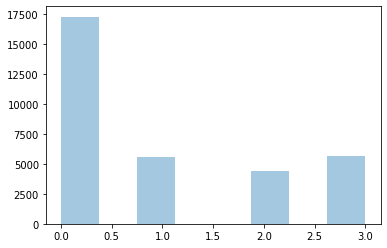

In [6]:
sns.distplot(data[:,-1],kde=False,bins=8)

## (e) Test Train Validation Split

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [8]:
X = data[:,:-1]
y = data[:,-1]

x_dev, x_test, y_dev, y_test = train_test_split(X,y, test_size=0.1, stratify=y)
x_train, x_cross, y_train, y_cross = train_test_split(x_dev,y_dev,test_size=0.1111,stratify=y_dev)

print(x_train.shape)
print(y_train.shape)
print(x_cross.shape)
print(y_cross.shape)
print(x_test.shape)
print(y_test.shape)

(26331, 75)
(26331,)
(3292, 75)
(3292,)
(3292, 75)
(3292,)


In [9]:
# base line accuracy
test_model = SGDClassifier()
test_model.fit(x_train,y_train)
y_pred = test_model.predict(x_cross)
print(f1_score(y_cross, y_pred, average='micro'))

0.6530984204131227


## (f) Feature selection

In [10]:
def select_features(train, cross, train_labels, cross_labels):
    selected = []
    validation_losses = []
    prev_best = 0
    for count_features in range(50):
        losses = [] 
        model = SGDClassifier()
        for col in range(x_train.shape[1]):
            
            if col in selected:
                continue

            candidate = selected.copy()
            candidate.append(col)
            
            model.fit(train[:,candidate], train_labels)
            y_pred = model.predict(cross[:,candidate])
            
            losses.append((f1_score(cross_labels, y_pred,average = 'micro'),col))

        # current best accuracies
        losses.sort(key=lambda x : x[0], reverse = True)
        selected.append(losses[0][1])
        validation_losses.append(losses[0][0])
    return selected,validation_losses

In [11]:
features,val_losses =select_features(x_train[:10000], x_cross, y_train[:10000], y_cross)

Text(0.5, 1.0, 'Validation accuracy V/S features')

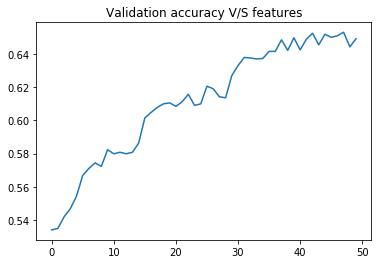

In [12]:
import seaborn as sns
import matplotlib as plt

ax = sns.lineplot(range(len(val_losses)),val_losses)
ax.set_title('Validation accuracy V/S features')


#### Selecting 30 features

In [13]:
model = SGDClassifier()
model.fit(x_train[:,features[:30]], y_train)
y_pred = model.predict(x_test[:,features[:30]])
acc = f1_score(y_test, y_pred,average = 'micro')
print("Testing Accuracy: ", acc)

Testing Accuracy:  0.6096597812879708


## (g) Feature transformation

In [14]:
from numpy import mean
from numpy import cov
from numpy.linalg import eig

M = mean(x_train.T, axis=1)
cx_train = x_train - M
cx_cross = x_cross - M
cx_test = x_test - M
V = cov(cx_train.T)

eig_values, eig_vectors = eig(V)

In [15]:
pca_s = []
pca_acc = []

for k in range(1,len(eig_values)+1):
    pca_model = SGDClassifier()
    mat_in = eig_vectors[:,:k].T.dot(cx_train.T)
    pca_model.fit(mat_in.T, y_train)
    cross_in = eig_vectors[:,:k].T.dot(cx_cross.T)
    y_pred = pca_model.predict(cross_in.T)
    acc = f1_score(y_cross, y_pred,average = 'micro')
    S = sum(eig_values[:k])/sum(eig_values)
    pca_s.append(S)
    pca_acc.append(acc)

Text(0.5, 1.0, 'PCA eigen values (S)')

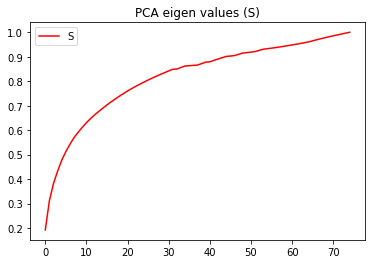

In [16]:
ax = sns.lineplot(range(len(pca_s)),pca_s,label="S",color='red')
ax.set_title('PCA eigen values (S)')

Text(0.5, 1.0, 'PCA Validation Accuracy')

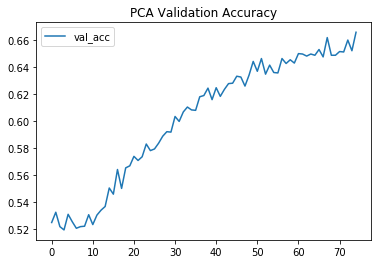

In [17]:
ax = sns.lineplot(range(len(pca_acc)),pca_acc,label="val_acc")
ax.set_title('PCA Validation Accuracy')

#### There is an approximately linear increase in validation accuracy. We will go for K = 50

In [18]:
k=50
pca_model = SGDClassifier()
mat_in = eig_vectors[:,:k].T.dot(cx_train.T)
pca_model.fit(mat_in.T, y_train)
test_in = eig_vectors[:,:k].T.dot(cx_test.T)
y_pred = pca_model.predict(test_in.T)
test_acc = f1_score(y_test, y_pred,average = 'micro')
print("Testing Accuracy: ",test_acc)

Testing Accuracy:  0.6303159173754557


## (h) SVM

### Comparing Kernels

In [19]:
from sklearn.svm import SVC
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    linear_svc = SVC(gamma = "auto",kernel=kernel)
    linear_svc.fit(x_train,y_train)
    y_pred = linear_svc.predict(x_cross)
    val_acc = f1_score(y_cross, y_pred,average = 'micro')
    print("Kernel: ",kernel)
    print("Validation F1: ",val_acc)

Kernel:  linear
Validation F1:  0.6649453219927096
Kernel:  poly
Validation F1:  0.6676792223572297
Kernel:  rbf
Validation F1:  0.68408262454435
Kernel:  sigmoid
Validation F1:  0.5042527339003645


#### Although the results are pretty close 'RBF' kernel gives the best accuracy.
Also, using 'RBF' seems reasonable for this classification task where we expect to have non-linear boundaries.<br>
We will fine tune the other parameters for this kernel type.

In [20]:
Cs = [0.1,0.01]
gammas = [0.1,0.01]

best_svm_acc = 0
best_c = None
best_gamma = None

for C in Cs:
    for gamma in gammas:
        linear_svc = SVC(C=C,gamma = gamma,kernel='rbf')
        linear_svc.fit(x_train,y_train)
        y_pred = linear_svc.predict(x_cross)
        val_acc = f1_score(y_cross, y_pred,average = 'micro')
        print("C: ",C,"Gamma: ",gamma)
        print("Validation F1: ",val_acc)
        if val_acc > best_svm_acc:
            best_svm_acc = val_acc
            best_c = C
            best_gamma = gamma

C:  0.1 Gamma:  0.1
Validation F1:  0.6497569866342648
C:  0.1 Gamma:  0.01
Validation F1:  0.5883961117861483
C:  0.01 Gamma:  0.1
Validation F1:  0.5252126366950183
C:  0.01 Gamma:  0.01
Validation F1:  0.5252126366950183


In [21]:
linear_svc = SVC(C=best_c,gamma = best_gamma,kernel='rbf')
linear_svc.fit(x_train,y_train)
y_pred = linear_svc.predict(x_test)
test_acc = f1_score(y_test, y_pred,average = 'micro')
print("Testing Accuracy: ", test_acc)

Testing Accuracy:  0.6464155528554071


## (i) Ensemble learning

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

estimators = [25,50,100]
learning_rates = [0.1,0.03]
best_acc = 0
best_n_est = None
best_lr = None

for n_est in estimators:
    for lr in learning_rates:
        ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=n_est,learning_rate=lr)
        ada_model.fit(x_train, y_train)
        y_pred = ada_model.predict(x_cross)
        acc = f1_score(y_cross, y_pred,average = 'micro')
        print("Num of Estimators: ",n_est,"\t\tLearning rate: ",lr)
        print("Val. Accuracy: ",acc)
        
        if acc > best_acc:
            best_n_est = n_est
            best_lr = lr

Num of Estimators:  25 		Learning rate:  0.1
Val. Accuracy:  0.6546172539489672
Num of Estimators:  25 		Learning rate:  0.03
Val. Accuracy:  0.6698055893074119
Num of Estimators:  50 		Learning rate:  0.1
Val. Accuracy:  0.6564398541919806
Num of Estimators:  50 		Learning rate:  0.03
Val. Accuracy:  0.6786148238153098
Num of Estimators:  100 		Learning rate:  0.1
Val. Accuracy:  0.6546172539489672
Num of Estimators:  100 		Learning rate:  0.03
Val. Accuracy:  0.6767922235722965


In [23]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=best_n_est,learning_rate=best_lr)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = f1_score(y_test, y_pred,average = 'micro')
print("Testing Accuracy: ", acc)

Testing Accuracy:  0.6643377885783718


#### As we can see, Adaboost gives significantly better performance than the feature selection and feature extraction methods beating the testing accuracies of both the methods.